In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import os
import json
import pathlib
import pandas as pd
import random
random.seed(42)

In [2]:
# import libs related to image
import cv2

In [3]:
# import libs related to machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import to_categorical

In [4]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [180, 180])
    image = image / 255.0 # normalize pixel values
    return image, label

In [5]:
data_dir = pathlib.Path('./images/')
images = data_dir.glob('*.jpg')
image_count = len(list(images))
image_count

100

In [6]:
# load the images path, data and labels
data = json.load(open('./images/_annotations.json'))

image_paths = []
labels = []
images_data = []
for filename in os.listdir(data_dir):
    image_path = os.path.join(data_dir, filename)
    if os.path.isfile(image_path) and (filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('jpeg')):
        image_paths.append(image_path)
        label = data['annotations'][filename][0]['label']
        labels.append(label)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (50, 50))
        images_data.append(image)
        
print(len(image_paths))

100


In [7]:
# normalize the images data
data = np.array(images_data, dtype="float") / 255.0
labels = np.array(labels)

In [17]:
# construct the training and testing data
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.1)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train[:5])  # Print the first 5 samples from the train features
print(X_test[:5])   # Print the first 5 samples from the test features
print(y_train[:5])  # Print the first 5 samples from the train labels
print(y_test[:5])   # Print the first 5 samples from the test labels

(90, 50, 50, 3)
(10, 50, 50, 3)
(90,)
(10,)
[[[[0.81568627 0.76078431 0.76470588]
   [0.80392157 0.74901961 0.77254902]
   [0.79215686 0.74117647 0.78039216]
   ...
   [0.00392157 0.02352941 0.2627451 ]
   [0.00392157 0.02745098 0.25882353]
   [0.00784314 0.02352941 0.24705882]]

  [[0.80392157 0.74117647 0.78039216]
   [0.78431373 0.72156863 0.76470588]
   [0.8        0.73333333 0.77647059]
   ...
   [0.01568627 0.03137255 0.28627451]
   [0.01568627 0.03137255 0.27843137]
   [0.01568627 0.03921569 0.26666667]]

  [[0.79215686 0.72156863 0.77254902]
   [0.81176471 0.74117647 0.79215686]
   [0.81176471 0.74509804 0.79215686]
   ...
   [0.00392157 0.01960784 0.23137255]
   [0.00392157 0.02745098 0.23529412]
   [0.00392157 0.02352941 0.23529412]]

  ...

  [[0.43529412 0.44705882 0.7372549 ]
   [0.42745098 0.44313725 0.7372549 ]
   [0.40392157 0.41960784 0.7254902 ]
   ...
   [0.27058824 0.45098039 0.96862745]
   [0.19215686 0.34117647 0.8627451 ]
   [0.19215686 0.31764706 0.81960784]]

 

In [19]:
# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
num_classes=2
model = Sequential([
    layers.Rescaling(1./255),
    # CONV => RELU => POOL
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # (CONV => RELU => POOL) * 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # (CONV => RELU => POOL) * 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # first (and only) set of FC => RELU layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # softmax classifier
    layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])
early_stopping = callbacks.EarlyStopping(
    min_delta = 0.01,
    patience = 5,
    restore_best_weights = True
)

In [24]:
# train the model
batch_size = 32
epochs = 120

history = model.fit(
    x = X_train,
    y = y_train,
    # validation_data=(X_test, y_test),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/120
3/3 [==============================] - 1s 375ms/step - loss: 0.0495 - accuracy: 0.9667
Epoch 2/120
3/3 [==============================] - 1s 355ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 3/120
3/3 [==============================] - 1s 360ms/step - loss: 0.0353 - accuracy: 0.9778
Epoch 4/120
3/3 [==============================] - 1s 365ms/step - loss: 0.0408 - accuracy: 0.9667
Epoch 5/120
3/3 [==============================] - 1s 357ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 6/120
3/3 [==============================] - 1s 347ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 7/120
3/3 [==============================] - 1s 339ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 8/120
3/3 [==============================] - 1s 357ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 9/120
3/3 [==============================] - 1s 359ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 10/120
3/3 [==============================] - 1s 362ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 11/

In [26]:
# Evaluating network
predictions = model.predict(x = X_test, batch_size = batch_size)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

1/1 [==============================] - 0s 104ms/step
              precision    recall  f1-score   support

      hotdog       0.33      0.20      0.25         5
  not_hotdog       0.43      0.60      0.50         5

    accuracy                           0.40        10
   macro avg       0.38      0.40      0.38        10
weighted avg       0.38      0.40      0.38        10



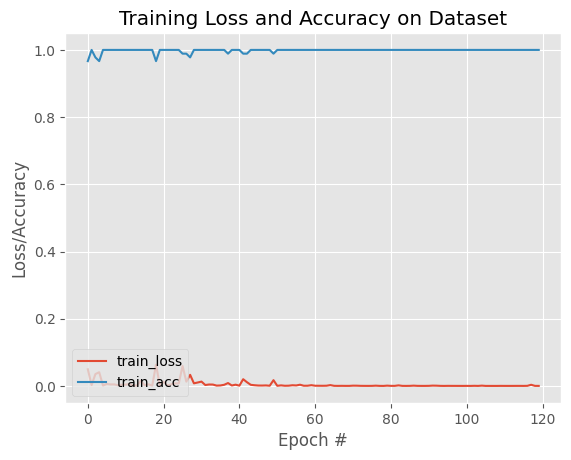

In [29]:
# plot the training loss and accuracy
N = 120
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [35]:
# make predicition on new data
image = cv2.imread('./test/3.jpg')
op = image.copy()
image = cv2.resize(image, (50, 50))

image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

print(image.shape)

# make prediction on image
preds = model.predict(image)
print(preds)
# # find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]
print(label)

(1, 50, 50, 3)
1/1 [==============================] - 0s 56ms/step
[[0.9989292  0.00107077]]
hotdog
